# Mission - Classifiez automatiquement des informations

Vous êtes mandaté en tant que Consultant Data Scientist par le département RH de votre client. Il s’agit de l'ESN TechNova Partners, spécialisée dans le conseil en transformation digitale et la vente d’applications en SaaS.
 
Ils font face à un turnover plus élevé que d'habitude et ils souhaitent identifier les causes racines potentielles derrière ces démissions.

### Importation des librairies

In [1]:
# Librairies "classiques"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
from IPython.display import Image, display
import shap

# Librairies scikit-learn
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV, 
    cross_validate,
)
# Preprocess et modèles
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_auc_score, auc, f1_score, balanced_accuracy_score
from sklearn.inspection import permutation_importance

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool

# Fonctions python créées
from utils import prepare_xy
from utils import scaler_ou_non

### On reprend les éléments du notebook de l'étape 2

In [2]:
donnees_modelisation = pd.read_csv("../Data/Processed/Projet_4_etape2_clean.csv")

# Partie 5 - Optimisez et interprétez le comportement du modèle

### Recommandation 1 - Reprenez les mêmes principes que le projet 3 (si vous suivez ce parcours dans sa totalité) pour le fine-tuning.
* Afin de trouver les meilleurs hyperparamètres de notre modèle sélectionné, CatBoost, nous utilisons un GridSearchCV pour les rechercher.

#### Récupération de notre séparation X et y et de nos features

In [3]:
X, y = prepare_xy(donnees_modelisation)
features_a_scaler, features_encodees = scaler_ou_non()

#### Recherche des hyperparamètres

In [4]:
# Séparation de X et y
X, y
# Test en jeu d'apprentissage et de test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=42, stratify = y)
# Transformation des colonnes et enregistrement dans un pipeline
preprocessor = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(),features_a_scaler),
        ('cat','passthrough',features_encodees)
    ])
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model',CatBoostClassifier(random_state = 42, verbose=0))
])
# Enregistrement des paramètres
param_grid = {
    'model__iterations' : [100, 200, 300, 500],
    'model__depth' : [2, 3, 4],
    'model__learning_rate' : [0.01, 0.02, 0.03, 0.04, 0.05],
    'model__class_weights' : [[1, 3], [1, 5], [1, 7]],
}
# Mise en place du GridSearchCV
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    estimator = pipeline,
    param_grid = param_grid,
    cv = cv,
    n_jobs = -1,
    scoring='recall', #choix du recall par logique avec l'étape précédente
    verbose = 0
)
# Entraînement du modèle
grid_search.fit(X_train, y_train)
# J'enregistre quel est le meilleur modèle, je réalise la prédiction et j'évalue
best_model = grid_search.best_estimator_
print("Meilleurs paramètres :", grid_search.best_params_)
print("Meilleur recall :", grid_search.best_score_)

Meilleurs paramètres : {'model__class_weights': [1, 7], 'model__depth': 2, 'model__iterations': 100, 'model__learning_rate': 0.01}
Meilleur recall : 0.8207671957671958


#### L'utilisation de GridSearchCV nous donne des hyperparamètres qui améliorent le racall de notre modèle par rapport à l'étape 4.

Les meilleurs paramètres sont :
* 'model__class_weights': [1, 7]
* 'model__depth': 2
* 'model__iterations': 100
* 'model__learning_rate': 0.01

### On peut désormais lancer une validation croisée avec nos nouveaux hyperparamètres optimisés 

In [8]:
# Séparation X/y
X, y = prepare_xy(donnees_modelisation)

# Récupération des features à scaler/passthrough 
features_a_scaler, features_encodees = scaler_ou_non()

# Split Train/Test avec stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify = y)
    
# Pipeline : prétraitements + modèle
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features_a_scaler),
        ('cat', 'passthrough', features_encodees)])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', CatBoostClassifier(
        iterations=100, #nombre d’arbres boostés
        depth=2, # profondeur des arbres
        learning_rate=0.01, # vitesse d’apprentissage
        class_weights=[1, 7], # pondération des classes
        random_state=42,
        verbose=0
    ))])

# Validation croisée sur l'entraînement (stockage moyennes/écarts-types)
scoring = ['precision', 'recall', 'f1', 'average_precision', 'balanced_accuracy']  # average_precision = PR AUC
cv = StratifiedKFold(n_splits=3)
cv_results = cross_validate(
    pipeline,
    X_train, y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1)

print("=== Résultats CV (train vs val) ===")
for metric in scoring:
    tr = cv_results[f"train_{metric}"]
    te = cv_results[f"test_{metric}"]
    print(f"{metric:18s}: train {tr.mean():.3f} ± {tr.std():.3f} vs val {te.mean():.3f} ± {te.std():.3f}")

=== Résultats CV (train vs val) ===
precision         : train 0.262 ± 0.013 vs val 0.235 ± 0.009
recall            : train 0.871 ± 0.032 vs val 0.795 ± 0.021
f1                : train 0.402 ± 0.017 vs val 0.362 ± 0.009
average_precision : train 0.581 ± 0.027 vs val 0.496 ± 0.050
balanced_accuracy : train 0.698 ± 0.020 vs val 0.647 ± 0.008


Sur le jeu d'entraînement notre modèle est amélioré sur le recall par rapport au jeu de test final :
* 0.795 vs 0.660 le seuil à 0.5
* 0.795 vs 0.766 le seuil optimal à 0.44

#### Dans la même logique que l'étape 4 nous allons recalculer le seuil optimal pour qu'il soit adapté à nos nouveaux paramètres.

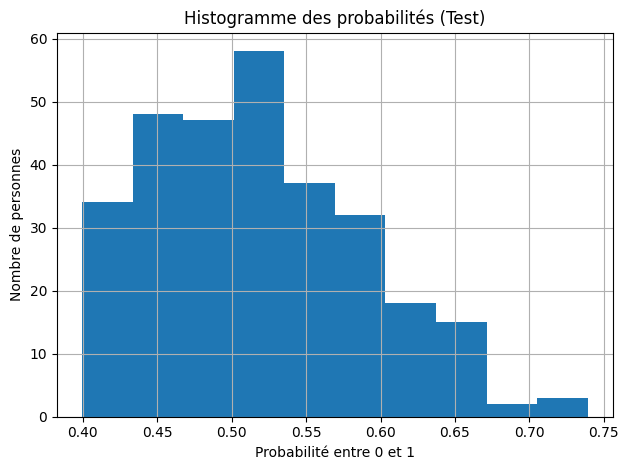

In [6]:
# Split interne Train/Validation pour choisir le seuil et entraînement de ce dernier
X_tr, X_val, y_tr, y_val = train_test_split(
X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

pipeline.fit(X_tr, y_tr)
proba_val = pipeline.predict_proba(X_val)[:,1] # Cette ligne récupère pour chaque individu du jeu X_val, la probabilité d’appartenir à la classe 1
precision_val, recall_val, thresholds_val = precision_recall_curve(y_val, proba_val)

# Création du seuil fbeta
beta = 2 # afin de mettre des poids supplémentaires sur le recall
f_beta = (1 + beta**2) * (precision_val * recall_val) / (beta**2 * precision_val + recall_val)
idx = int(np.nanargmax(f_beta))
best_thr = float(thresholds_val[idx])

pipeline.fit(X_train, y_train)
# Évaluation TEST (sans rechoisir le seuil, soit 0,5)
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)
proba_test = pipeline.predict_proba(X_test)[:, 1]

# Histogramme des probabilités (Test)
plt.hist(proba_test)
plt.title("Histogramme des probabilités (Test)")
plt.xlabel("Probabilité entre 0 et 1")
plt.ylabel("Nombre de personnes")
plt.grid()
plt.tight_layout()
plt.show()

Par rapport au précédent histogramme, on peut observer que la concentration qui était entre 0.2 et 0.5 se situe un peu plus haut désormais, le modèle est toujours peu confiant.

#### Courbe de la précision-rappel et détermination du seuil fbeta

PR AUC (Average Precision) — TEST : 0.510


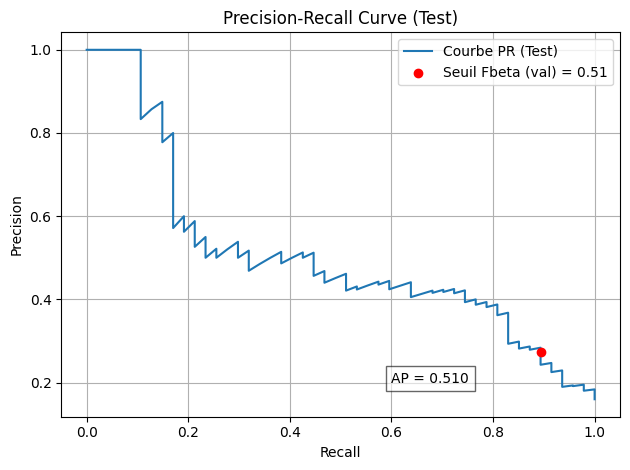

In [7]:
ap_test = average_precision_score(y_test, proba_test)   # PR AUC (Average Precision) — Test
print(f"PR AUC (Average Precision) — TEST : {ap_test:.3f}")
# Courbe PR (Test) pour visualiser + point au seuil optimal
precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, proba_test)
# Point obtenu par application du seuil sur test
y_pred_custom = (proba_test >= best_thr).astype(int)
tp = ((y_test==1) & (y_pred_custom==1)).sum()
fp = ((y_test==0) & (y_pred_custom==1)).sum()
fn = ((y_test==1) & (y_pred_custom==0)).sum()
prec_pt = tp / (tp + fp)
rec_pt  = tp / (tp + fn)
plt.plot(recall_test, precision_test, label="Courbe PR (Test)")
plt.scatter(rec_pt, prec_pt, color="red", zorder=5, label=f"Seuil Fbeta (val) = {best_thr:.2f}")
plt.text(0.6, 0.2, f"AP = {ap_test:.3f}", fontsize=10, bbox=dict(facecolor='white', alpha=0.6))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Test)")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

* Le seuil est désormais à 0.51, non loin du seuil standard.

In [10]:
print("=== balanced accuracy score - TEST (0.5) ===")
print(round(balanced_accuracy_score(y_test, y_pred_test), 3))
print(f"=== balanced accuracy score - TEST (seuil F{beta:.1f} VALIDATION) ===")
print(round(balanced_accuracy_score(y_test, y_pred_custom), 3))

=== balanced accuracy score - TEST (0.5) ===
0.694
=== balanced accuracy score - TEST (seuil F2.0 VALIDATION) ===
0.72


* Le score de la balanced_accuracy est légèrement meilleur avec le seuil optimal, on obtient donc un meilleur équilibre entre la précision-rappel.

#### Classification report

In [11]:
print("=== Classification Report - TRAIN ===")
print(classification_report(y_train, y_pred_train, digits=3))
print("=== Classification Report - TEST (0.5) ===")
print(classification_report(y_test, y_pred_test, digits=3))
print(f"=== Classification Report — TEST (seuil F{beta:.1f} VALIDATION) ===")
print(classification_report(y_test, y_pred_custom, digits=3))

=== Classification Report - TRAIN ===
              precision    recall  f1-score   support

           0      0.952     0.521     0.674       986
           1      0.258     0.863     0.397       190

    accuracy                          0.577      1176
   macro avg      0.605     0.692     0.535      1176
weighted avg      0.840     0.577     0.629      1176

=== Classification Report - TEST (0.5) ===
              precision    recall  f1-score   support

           0      0.961     0.494     0.652       247
           1      0.251     0.894     0.393        47

    accuracy                          0.558       294
   macro avg      0.606     0.694     0.522       294
weighted avg      0.847     0.558     0.611       294

=== Classification Report — TEST (seuil F2.0 VALIDATION) ===
              precision    recall  f1-score   support

           0      0.964     0.547     0.698       247
           1      0.273     0.894     0.418        47

    accuracy                          0.

Entre le seuil standard et le seuil optimal, pas d'amélioration, ce qui est logique car le seuil est très semblable. 
* On a un très bon recall de l'ordre de 90% pour une précision plus faible de 27%. Nous gardons la logique du contexte métier, nous voulons rater le moins de départs possible au prix de considérer plus de faux positifs.

In [12]:
cm_test  = confusion_matrix(y_test, y_pred_test)
print("=== Matrice de confusion - TEST (0.5) ===")
print(cm_test)

cm_test_optimal  = confusion_matrix(y_test, y_pred_custom)
print(f"=== Matrice de confusion - TEST (seuil F{beta:.1f} VALIDATION) ===")
print(cm_test_optimal)

=== Matrice de confusion - TEST (0.5) ===
[[122 125]
 [  5  42]]
=== Matrice de confusion - TEST (seuil F2.0 VALIDATION) ===
[[135 112]
 [  5  42]]


### Recommandation 2 : Commencez d’abord par la feature importance globale, moins complexe, avant de passer à la locale.

### Feature importance globale de notre modèle

In [13]:
# Récupération du modèle CatBoost à l'intérieur du pipeline
cat = best_model.named_steps['model']

# Récupération des noms de features après préprocessing
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

# Importances globales
importances = cat.get_feature_importance()

# Mettre en DataFrame pour plus de lisibilité
fi_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print(fi_df.head(15))  # top 15

                            Feature  Importance
10       cat__heure_supplementaires   24.355417
1     num__annees_dans_l_entreprise   19.652504
0               num__revenu_mensuel   18.047449
7           num__pee_par_anciennete   14.946319
13                 cat__tranche_age    8.619384
5           num__score_satisfaction    6.719647
11       cat__frequence_deplacement    2.792562
4           num__experience_externe    1.193171
2    num__distance_domicile_travail    1.084942
19       cat__poste_CadreCommercial    0.620693
14  cat__statut_marital_Celibataire    0.611045
22               cat__poste_Manager    0.383161
21    cat__poste_DirecteurTechnique    0.370136
6   num__augmentation_par_formation    0.312728
8             num__niveau_education    0.223294


#### Graphique de la feature importance

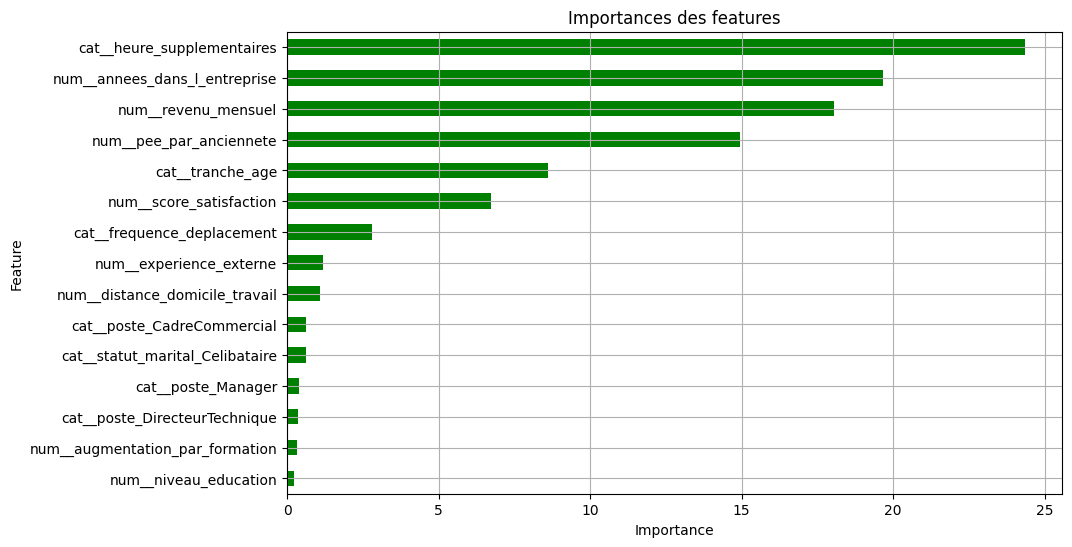

In [14]:
top_features = fi_df.nlargest(15, 'Importance')
top_features.sort_values(by="Importance", ascending=True).plot(
    x="Feature",
    y="Importance",
    kind="barh",
    legend=False,
    figsize=(10,6),
    color="green"
)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Importances des features")
plt.grid()
plt.show()

On peut identifier 6 variables importantes et qui dominent les autres features :

- cat__heure_supplementaires
- num__annees_dans_l_entreprise
- num__revenu_mensuel
- num__pee_par_anciennete
- cat__tranche_age
- num__score_satisfaction

### Recommandation 3 : Comparez plusieurs méthodes de feature importance globale et analysez leur points de convergence et de divergence. Vous pouvez comparer à minima la Permutation Importance de sklearn avec le Beeswarm Plot du package SHAP. Si votre modèle optimisé est à base d’arbre, vous pouvez également inclure sa feature importance native dans la comparaison.

### Permutation importance

* La permutation importance va nous permettre également de mesurer l'importance des variables mais d'une façon un peu différente. Cette technique consiste à changer de manière aléatoire les données d'une variable pour en calculer son impact sur le modèle.

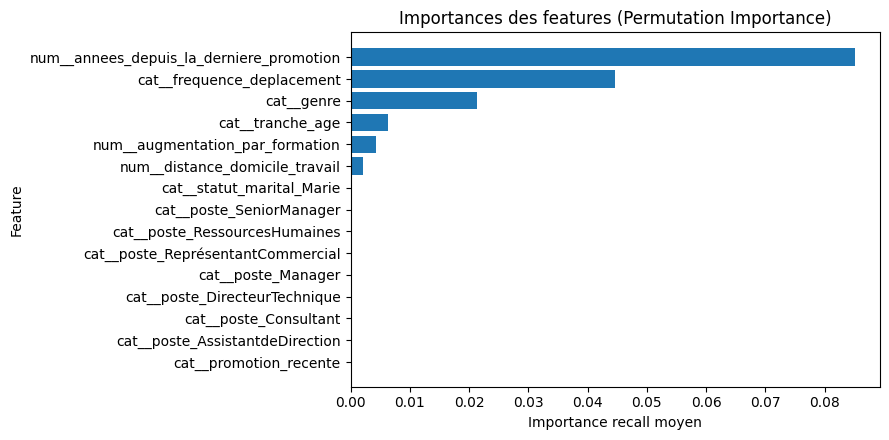


=== Permutation importance — Top 15 ===
                                 feature  importance_mean  importance_std
num__annees_depuis_la_derniere_promotion         0.085106        0.023307
              cat__frequence_deplacement         0.044681        0.030759
                              cat__genre         0.021277        0.016481
                        cat__tranche_age         0.006383        0.013624
         num__augmentation_par_formation         0.004255        0.008511
          num__distance_domicile_travail         0.002128        0.024166
               cat__statut_marital_Marie         0.000000        0.000000
                cat__poste_SeniorManager         0.000000        0.000000
           cat__poste_RessourcesHumaines         0.000000        0.000000
       cat__poste_ReprésentantCommercial         0.000000        0.000000
                      cat__poste_Manager         0.000000        0.000000
           cat__poste_DirecteurTechnique         0.000000        0.0000

In [15]:
# Ajout de la permutation_importance
perm = permutation_importance(
    estimator=best_model,
    X=X_test,
    y=y_test,
    scoring='recall',
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)
# Création d'un DataFrame des importances
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
perm_df = (
    pd.DataFrame({
        'feature': feature_names,
        'importance_mean': perm.importances_mean,
        'importance_std': perm.importances_std
    })
    .sort_values('importance_mean', ascending=False)
)
# Top 15 pour lisibilité
topk = 15
top_df = perm_df.head(topk).iloc[::-1] 

# Graphique
plt.figure(figsize=(9, 4.5))
plt.barh(top_df['feature'], top_df['importance_mean'])
plt.title("Importances des features (Permutation Importance)")
plt.xlabel("Importance recall moyen") 
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Afficher le tableau Top 15
print("\n=== Permutation importance — Top 15 ===")
print(top_df.iloc[::-1].to_string(index=False)) 

* Concentration de la permutation importance dans 6 variables. 4 d'entres elles se retouvent dans le top 15 de la feature importance mais seulement 1 dans le top 5.
* De manière surprenante nous ne retrouvons pas revenu_mensuel dans le top de ce classement. 

### Recommandation 4 : Si vous utilisez un modèle à base d’arbre, privilégiez l’utilisation du TreeExplainer du package SHAP. Sinon, vous pouvez utiliser le KernelExplainer, plus généraliste.

### Continuons l'analyse de manière globale avec le Beeswarm de l'analyse de SHAP

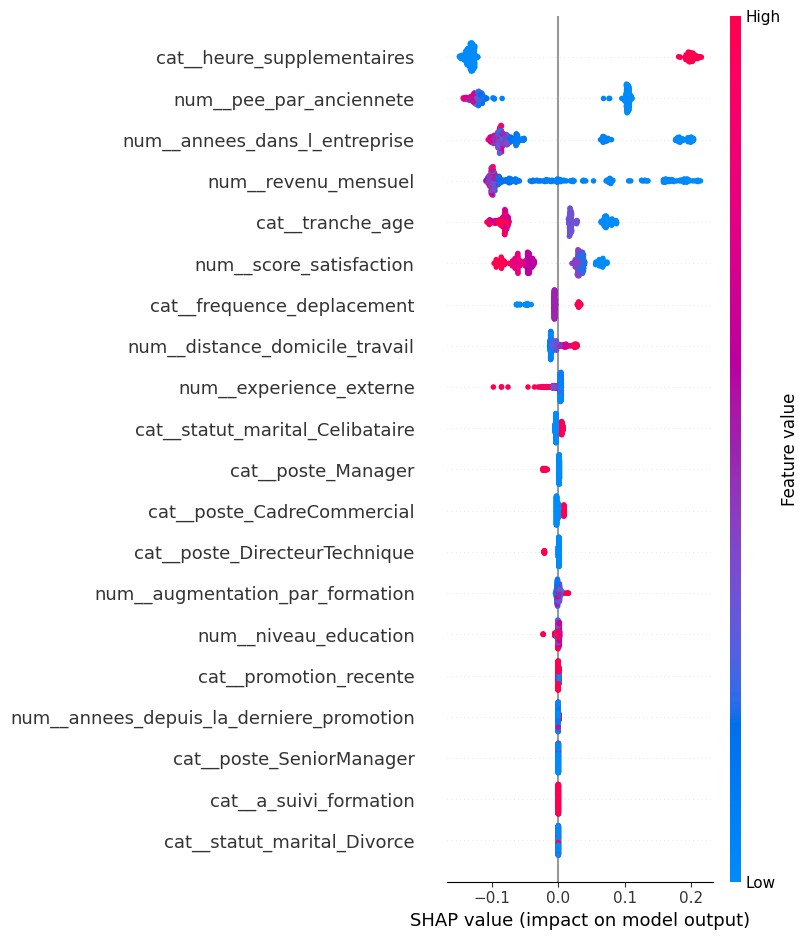

In [16]:
# Récupérer modèle CatBoost
cat = best_model.named_steps['model']

# Transformer X_test pour correspondre au format attendu
X_trans = best_model.named_steps['preprocessor'].transform(X_test)
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

# Créer l’explainer SHAP
explainer = shap.TreeExplainer(cat)

# Calculer les SHAP values
shap_values = explainer.shap_values(X_trans)

# Graphique de beeswarm
shap.summary_plot(shap_values, X_trans, feature_names=feature_names)


#### On peut noter ici plusieurs choses intéressantes :
* On voit que les salariés avec un revenu mensuel bas ont une plus grande probabilité de partir alors que les salaires les plus hauts ont une probabilité plus faible de départ. Notre intuition dans les étapes précédentes suit cette logique.
* On voit que les salariés qui réalisent des heures supplémentaires ont une probabilité plus grande de partir que ceux qui n'en font pas.
* Plus de probabilité de départ pour des personnes arrivés il n'y a pas longtemps dans l'entreprise. Ce qui explique également le nombre de PEE plus faible qui indique un score de proba vers le départ.
* Plus de départs possibles dans une tranche d'âge plus jeune


### Recommandation 5 : Assurez-vous de bien comprendre le sens des Shapley values en utilisant la fonction shap.plots.scatter() et son argument “color”.

#### Pour la variable revenu_mensuel

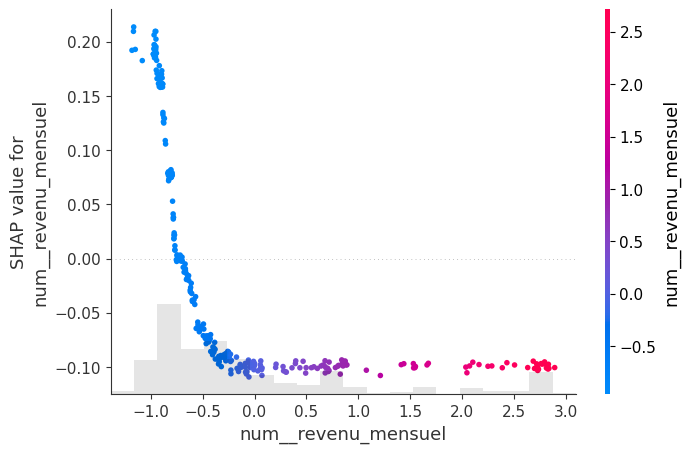

In [23]:
# Données transformées + noms
X_trans = best_model.named_steps['preprocessor'].transform(X_test)
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
X_df = pd.DataFrame(X_trans, columns=feature_names)

# Explainer + Explanation object
cat = best_model.named_steps['model']
explainer = shap.TreeExplainer(cat)
sv = explainer(X_df, check_additivity=False) 

# Scatter
shap.plots.scatter(
    sv[:, "num__revenu_mensuel"],
    color=sv[:, "num__revenu_mensuel"]
)

L’analyse SHAP de la variable revenu_mensuel montre que les bas salaires sont fortement associés à une augmentation du risque de démission, alors que les salaires élevés tendent au contraire à réduire ce risque. Cette relation est cohérente avec une intuition métier, une meilleure rémunération peut limiter le turnover, alors qu’une rémunération trop faible peut pousser au départ.

#### Pour la variable années dans l'entreprise

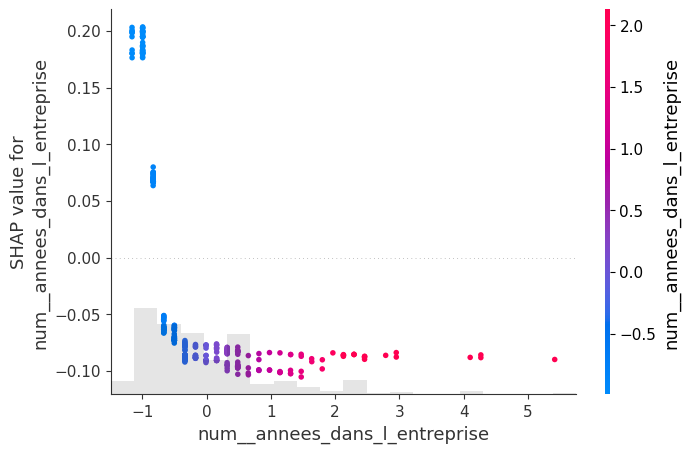

In [28]:
# Données transformées + noms
X_trans = best_model.named_steps['preprocessor'].transform(X_test)
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
X_df = pd.DataFrame(X_trans, columns=feature_names)

# Explainer + Explanation object
cat = best_model.named_steps['model']
explainer = shap.TreeExplainer(cat)
sv = explainer(X_df, check_additivity=False) 

# Scatter
shap.plots.scatter(
    sv[:, "num__annees_dans_l_entreprise"],
    color=sv[:, "num__annees_dans_l_entreprise"]
)

On voit une probabilité plus forte de départs pour ceux qui ont le moins d'ancienneté dans l'entreprise alors que les plus anciens ont plus de probabilité à rester.

### Recommandation 6 : Pour la feature importance locale, utilisez le Waterfall Plot. Choisissez quelques exemples issus des 2 classes.

### Attaquons nous à la feature locale
#### L'idée ici va être de regarder le comportement des features au cas par cas. Regardons plusieurs exemples.

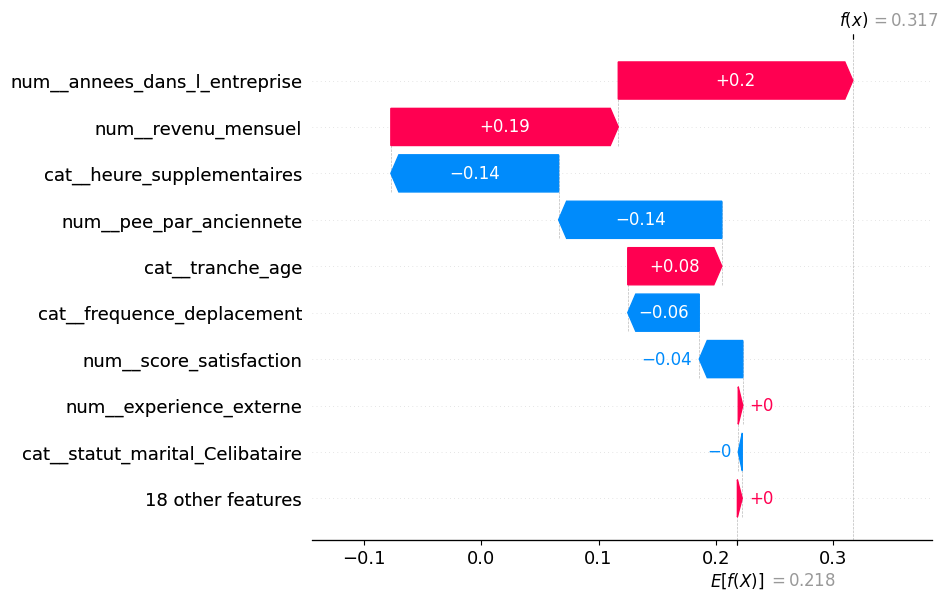

In [17]:
# Récupérer modèle CatBoost
cat = best_model.named_steps['model']

# Transformer X_test pour correspondre au format attendu
X_trans = best_model.named_steps['preprocessor'].transform(X_test)
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

# Créer l’explainer SHAP
explainer = shap.TreeExplainer(cat)

# Calculer les SHAP values
shap_values = explainer.shap_values(X_trans)

# Exemple local (waterfall sur le 1er individu)
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value,
    shap_values[0],
    feature_names=feature_names
)

On peut déjà noter la présence d'un indicateur de référence à 0.218 (moyenne de base) et les différentes features ont poussé la valeur prédictive à 0.317.
* Le nombre d'années dans l'entreprise pousse la prédiction vers la classe 1 ainsi que le revenu mensuel.
* Alors que nous voyons que la variable d'heures supplémentaires/celle de PEE ainsi que la fréquence de déplacement ont fait baisser le score de probabilité vers le bas.

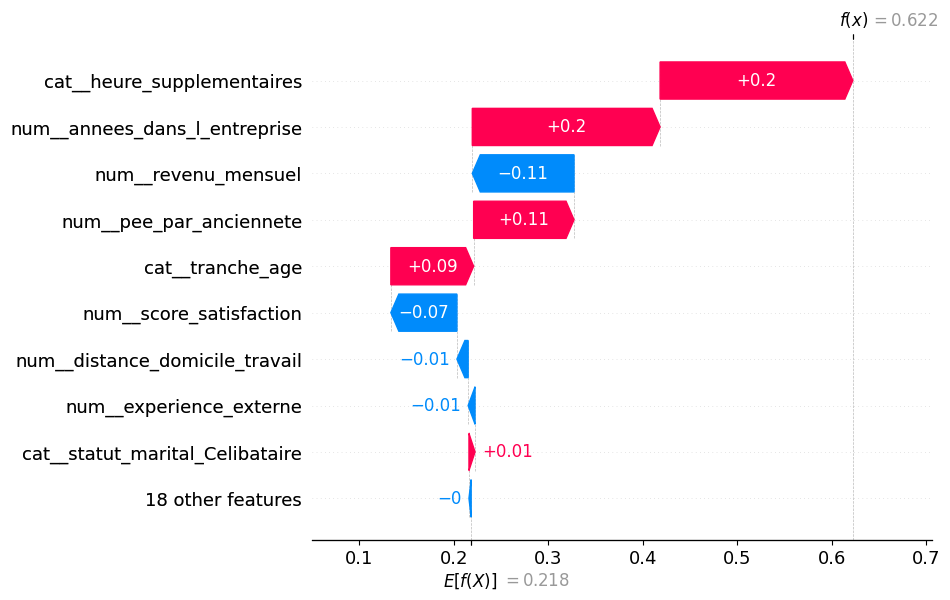

In [18]:
# Récupérer modèle CatBoost
cat = best_model.named_steps['model']

# Transformer X_test pour correspondre au format attendu
X_trans = best_model.named_steps['preprocessor'].transform(X_test)
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

# Créer l’explainer SHAP
explainer = shap.TreeExplainer(cat)

# Calculer les SHAP values
shap_values = explainer.shap_values(X_trans)

# Exemple local (waterfall sur le 17ième individu)
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value,
    shap_values[18],
    feature_names=feature_names
)

La probabilité de base est de 0.218 et elle passe à 0.622 avec les features pour ce salarié.
* Les features déterminantes quant à son départ sont les heures supplémentaires, le nombre d'années dans l'entreprise, le PEE et la tranche d'âge. Par contre dans ce cas précis le revenu mensuel pousse le modèle vers le bas.